This was created for a blog post on Gaussian Processes but I included a basic bayesian regression in there somewhere along the way when I was testing something. I though I'd leave it in there. If it is of no interest to you. Start from the second section "Understanding Gaussian Processes".

## Bayesian Regression

In [7]:
%matplotlib inline

In [339]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.api import OLS, add_constant, RLM
from sklearn.datasets import make_regression

import theano as th

In [562]:
FIG_PATH = "../../sidravi1.github.io/assets/"

In [20]:
sns.set_style("darkgrid")

In [517]:
X, y, betas = make_regression(100, 1, 1, bias=50, noise=40, coef=True)
betas

array(95.42949647413734)

In [520]:
ytrue = (X*betas + 50).squeeze()

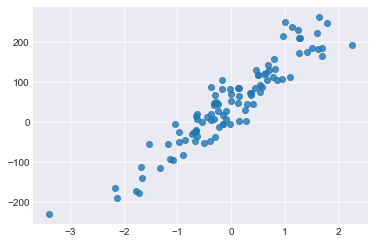

In [521]:
plt.scatter(X, y, alpha = 0.8)

In [522]:
m = RLM(y, add_constant(X), hasconst=True).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            RLM   Df Residuals:                       98
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 07 Apr 2018                                         
Time:                        15:46:02                                         
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3115      3.858     12.003      0.000      38.749      53.874
x1            99.8052      3.919     25.468      0.000      92.124     107.486
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [523]:
yols = m.predict()

### Kernels

In [484]:
x = np.random.normal(0, 1, 1000)
phi = lambda x: np.array([x, x**2, x**3, x**4]) 

In [487]:
x_high = phi(x).T

In [489]:
x_high.T.dot(x_high)

array([[  1036.69366288,   -164.72775426,   2865.5199878 ,   -835.91375232],
       [  -164.72775426,   2865.5199878 ,   -835.91375232,  12010.94115354],
       [  2865.5199878 ,   -835.91375232,  12010.94115354,  -5277.25967272],
       [  -835.91375232,  12010.94115354,  -5277.25967272,  64528.24829144]])

### Setup simple bayesian model

In [239]:
with pm.Model() as bayesm:
    intercept = pm.Normal("intercept", 0, 20)
    beta = pm.Normal("beta",0, 100, shape=1)
    noise = pm.HalfNormal("noise", sd= 20)
    mu = pm.Deterministic("yhat", intercept + th.dot(X, beta))
    likelihood = pm.Normal("y", mu = mu, sd=noise, observed=y)

In [240]:
with bayesm:
    tr = pm.sample(3000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise_log__, beta, intercept]
100%|██████████| 3500/3500 [00:04<00:00, 861.48it/s]


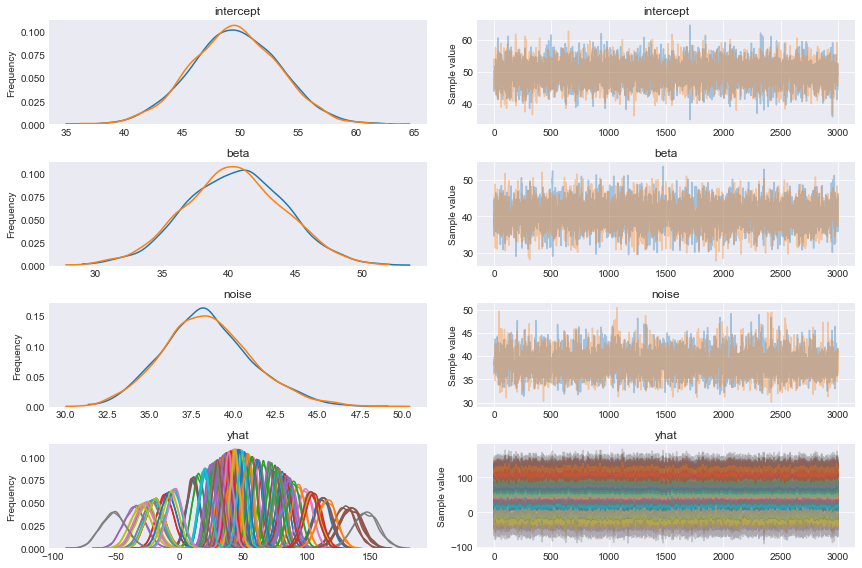

In [241]:
_ = pm.traceplot(tr)

In [244]:
yhat_map = pm.find_MAP(model=bayesm)['yhat']
yhat_mean = tr['yhat'].mean(0)
yhat_sd = tr['yhat'].std(0, ddof=1)

logp = -524.07, ||grad|| = 0.00044937: 100%|██████████| 33/33 [00:00<00:00, 602.86it/s]  


In [318]:
yh, yl = yhat_mean + yhat_sd, yhat_mean - yhat_sd

In [319]:
X = X.squeeze()

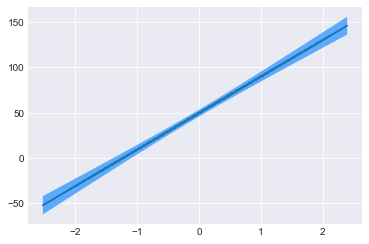

In [333]:
plt.plot(X, yhat_mean)
ys = np.stack((X, yh, yl))
ys = np.sort(ys, axis=1)
plt.fill_between(ys[0,:], ys[1,:], ys[2,:], facecolor='dodgerblue', alpha=0.7)


## Understanding Gaussian Processes

### Data Setup

In [573]:
def f(x):
    return x**.5*np.sin(x/2)*np.sin(2*x) + np.random.normal()

def f_noisless(x):
    return x**.5*np.sin(x/2)*np.sin(2*x)

In [575]:
x_data = np.linspace(0, 20, 20)
y_data = f_noisless(x_data)

In [565]:
X = th.shared(x)

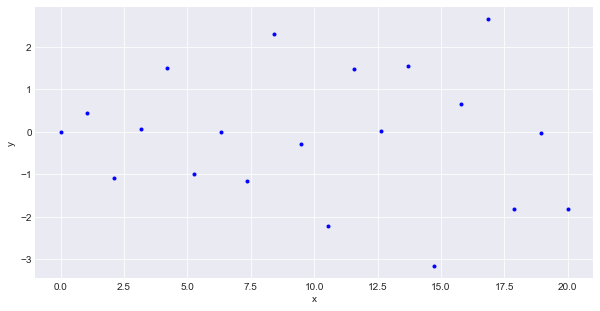

In [576]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(FIG_PATH + "2014_04_03_random_dot.png")

### 3rd order polynomial

In [443]:
order = 3
X = np.stack([x, x**2, x**3])
X_th = th.shared(X)

In [417]:
with pm.Model() as bayesm:
    intercept = pm.Normal("intercept", 0, 20)
    beta = pm.Normal("beta",0, 100, shape=order)
    noise = pm.HalfNormal("noise", sd= 20)
    mu = pm.Deterministic("yhat", intercept + th.dot(beta, X_th))
    likelihood = pm.Normal("y", mu = mu, sd=noise, observed=y)
    
    tr = pm.sample(3000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise_log__, beta, intercept]
100%|██████████| 3500/3500 [00:58<00:00, 59.35it/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2eed0b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2d296a58>]], dtype=object)

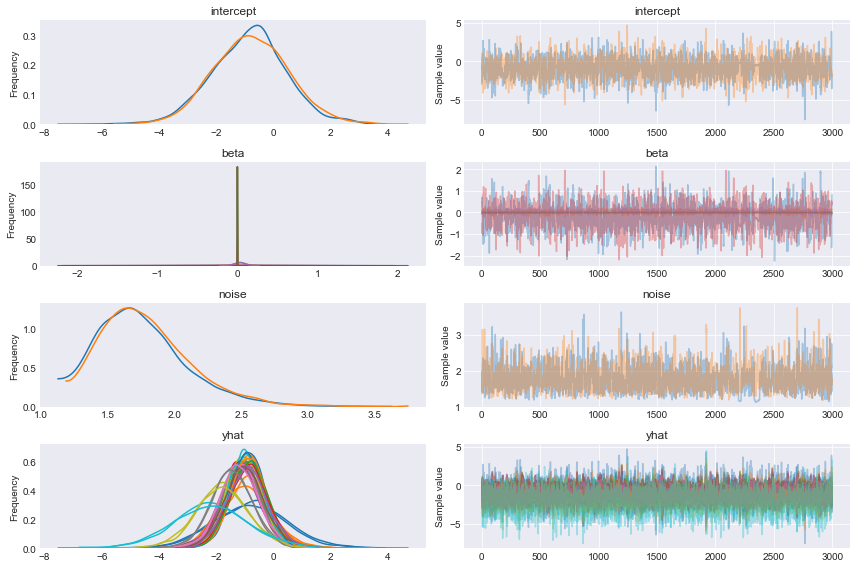

In [418]:
_ = pm.traceplot(tr)

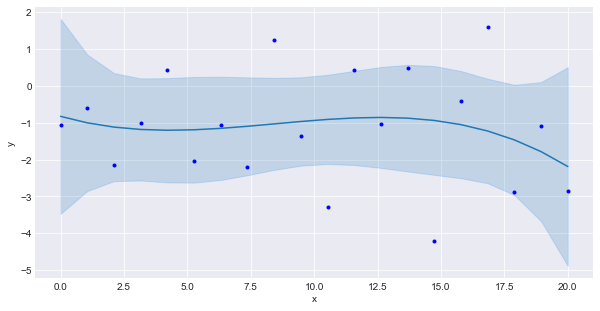

In [442]:
plt.figure(figsize=(10,5))
plt.plot(x, y, 'b.')
plt.xlabel("x")
plt.ylabel("y")
yhat = tr['yhat'].mean(0)
yhat_sd = tr['yhat'].std(0,ddof=1)
plt.plot(x, yhat)
plt.fill_between(x, yhat + 2*yhat_sd, yhat - 2*yhat_sd, alpha=0.2, edgecolor='dodgerblue')

### 20th order polynomial

In [528]:
order = 10
features = []
for o in range(order):
    v = x**(o)
    features.append(v)
    
X = np.stack(features)
X_th = th.shared(X)

In [529]:
np.shape(X)

(10, 20)

In [530]:
with pm.Model() as bayesm:
    intercept = pm.Normal("intercept", 0, 20)
    beta = pm.Normal("beta",0, 20, shape=order)
    noise = pm.HalfNormal("noise", sd= 20)
    mu = pm.Deterministic("yhat", intercept + th.dot(beta, X))
    likelihood = pm.Normal("y", mu = mu, sd=noise, observed=y)
    
    sampler = pm.NUTS()
    tr = pm.sample(3000, tune=1000, init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise_log__, beta, intercept]
100%|██████████| 4000/4000 [09:33<00:00,  6.97it/s]
There were 679 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.639011120815, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.934892861398, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


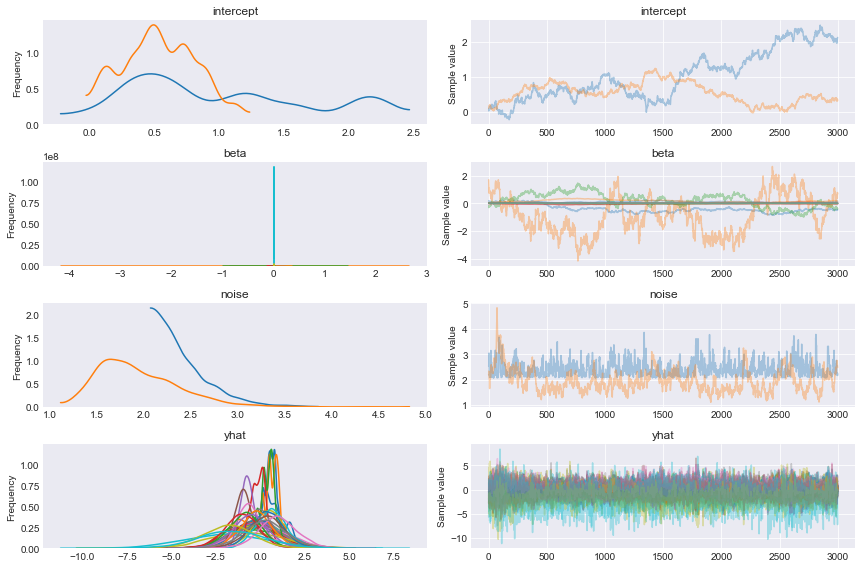

In [531]:
_ = pm.traceplot(tr)

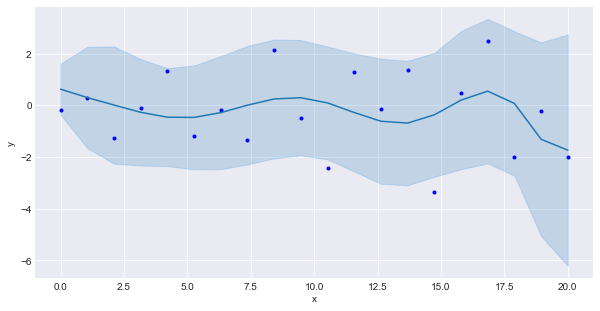

In [532]:
plt.figure(figsize=(10,5))
plt.plot(x, y, 'b.')
plt.xlabel("x")
plt.ylabel("y")
yhat = tr['yhat'].mean(0)
yhat_sd = tr['yhat'].std(0,ddof=1)
plt.plot(x, yhat)
plt.fill_between(x, yhat + 2*yhat_sd, yhat - 2*yhat_sd, alpha=0.2, edgecolor='dodgerblue')

### Gaussian process from scratch

#### What do some of these gaussian process functions looks like?

Let's plot for 50 points between 0 and 20. So we'll draw 50 points from a 50 dimensional multivariate. Yes this is hardly infinite dimensions but you never really do this calculation because of the wonderful properties of a Gaussian.

In [535]:
def get_covariance_matrix(kernel, x1, x2, params): 
    ''' Take the kernel function, and observations, and return the Gram matrix'''
    return np.array([[kernel(xi1, xi2, params) for xi1 in x1] for xi2 in x2])

def rbf_kernel(x1, x2, params):
    ''' Calculates the rbf kernel'''
    l = params['l']
    sig = params['sig']
    
    return (sig**2) * np.exp(-((x1 - x2)**2)/(2*(l**2)))


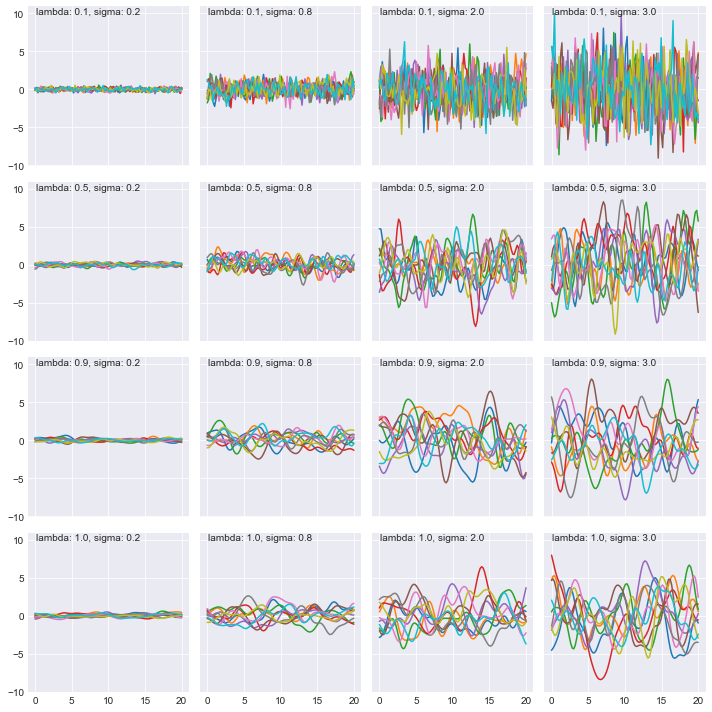

In [607]:
ls = [0.1, 0.5, 0.9, 1.0]
sigs = [0.2, 0.8, 2.0, 3.0]

nsamps = 100
x = np.linspace(0,20,nsamps)
f, axes = plt.subplots(4,4,figsize=(10, 10), sharex=True, sharey=True)

for l, col_axes in zip(ls, axes):
    for a, ax in zip(sigs, col_axes):
        sigma = get_covariance_matrix(rbf_kernel, x , x, {'l':l, 'sig':a}) # + np.eye(nsamps)*1e-06 # just uncomment if you want to add noise
        for i in range(10):
            samples = np.random.multivariate_normal(np.zeros(nsamps), sigma)
            ax.plot(x, samples)
        ax.annotate("lambda: {}, sigma: {}".format(l, a), xy = (0.05, 0.95), xycoords = 'axes fraction')
            
plt.tight_layout()
plt.savefig("../../sidravi1.github.io/assets/2014_04_03_random_gaussian_func.png")

#### Let's calculate the posterior given the data points

In [615]:
## Note how this is different from get_covariance_matrix.
covariance = lambda kernel, X1, X2, params: np.array([[kernel(xi, x2i, params) for x2i in X2] for xi in X1])

In [610]:
def conditional(x_new, x, f, cov_func, params):
    B = covariance(cov_func, x_new, x, params)
    C = covariance(cov_func, x, x, params)
    A = covariance(cov_func, x_new, x_new, params)
    Cinv=np.linalg.inv(C)
    mu = np.dot(np.dot(B, Cinv),f)
    sigma = A - np.dot(np.dot(B, Cinv), B.T)
    return mu.squeeze(), sigma.squeeze()

In [611]:
gp_params={'l':0.6,'sig':1}
munew, snew = conditional(x, x_data, y_data, rbf_kernel, gp_params)
print(munew.shape, snew.shape)
signews = np.diagonal(snew)

(100,) (100, 100)


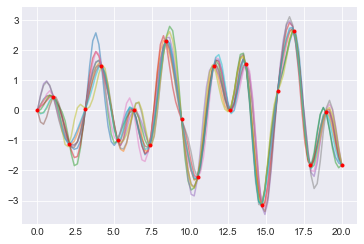

In [614]:
for i in range(10):
    samples = np.random.multivariate_normal(munew, snew)
    plt.plot(x, samples,alpha = 0.5)
plt.plot(x_data, y_data, "r.")

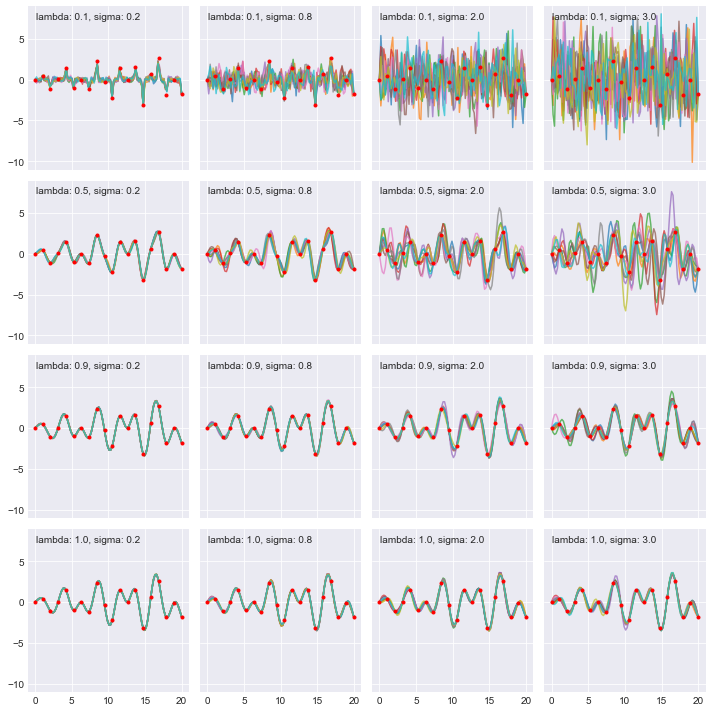

In [603]:
ls = [0.1, 0.5, 0.9, 1.0]
sigs = [0.2, 0.8, 2.0, 3.0]

f, axes = plt.subplots(4,4,figsize=(10, 10), sharex=True, sharey=True)

for l, col_axes in zip(ls, axes):
    for a, ax in zip(sigs, col_axes):
        munew, snew = conditional(x, x_data, y_data, rbf_kernel, {'l':l, 'sig':a})
        for i in range(10):
            samples = np.random.multivariate_normal(munew, snew)
            ax.plot(x, samples, alpha=0.7)
        ax.annotate("lambda: {}, sigma: {}".format(l, a), xy = (0.05, 0.92), xycoords = 'axes fraction')
        ax.plot(x_data, y_data, "r.")   
plt.tight_layout()
plt.savefig("../../sidravi1.github.io/assets/2014_04_03_conditional_gaussian_func.png")